**Frequency computations** 

The purpose of this script is to load all processed epochs and compute metrics of interest in the frequency domain and save it as a pickle file for each subject in each dataset as task type. 

In [1]:
# Importing dependencies
import mne
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pickle

**Functions**

In [4]:
def load_epochs(task_type, subject, task, state=None, preload=True):
    """
    Load MNE epochs for a specified task type, subject, task, and state.
    
    Parameters:
    - task_type (str): Type of task ('internal_task' or 'external_task').
    - subject (str): Subject identifier (e.g., '001').
    - task (str): Task name (e.g., 'task_name').
    - state (str): State associated with the task (e.g., 'state_name').
    - preload (bool, optional): Whether to preload the epochs into memory. Default is True.
    
    Returns:
    - mne.Epochs: The filtered epochs object.
    
    Raises:
    - ValueError: If `task_type` is invalid or required keys are missing.
    - FileNotFoundError: If the specified files do not exist.
    """

    if task_type not in ['internal_task', 'external_task']:
        raise ValueError("task_type must be either 'internal_task' or 'external_task'")

    if task_type == 'external_task':
        # Handle external task sessions
        sessions = ['ses-1', 'ses-2']
        epochs_list = []
        state = state.upper()

        for session in sessions:
            file_path = f'./epochs/external_task/sub-{subject}_{session}_epo.fif'
            if os.path.exists(file_path):
                print(f"Loading {file_path}")
                epochs = mne.read_epochs(file_path, preload=preload)
                epochs_list.append(epochs)
            else:
                print(f"Warning: Session {session} not found for subject {subject}")
        
        if not epochs_list:
            raise FileNotFoundError(f"No sessions found for subject {subject}")
        
        epochs = mne.concatenate_epochs(epochs_list)

        # Filter epochs based on task and state
        if task == 'combined':
            combined_event_ids = [key for key in epochs.event_id if any(f"{t}/{state}" in key for t in ['vs', 'sart'])]
            if not combined_event_ids:
                raise ValueError(f"State '{state}' not found in event_id of epochs for tasks 'vs' and 'sart'")
            epochs = epochs[combined_event_ids]
        else:
            event_id = next((key for key in epochs.event_id if f"{task}/{state}" in key), None)
            if not event_id:
                raise ValueError(f"Task '{task}' with state '{state}' not found in event_id of epochs")
            epochs = epochs[event_id]

    else:  # Handle internal task
        file_path = f'./epochs/internal_task/sub-{subject}_epo.fif'
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"No epochs found for subject {subject} at {file_path}")

        print(f"Loading {file_path}")
        epochs = mne.read_epochs(file_path, preload=preload)

        # Retrieve the group from event_id
        group = next((key.split('/')[0] for key in epochs.event_id if '/' in key), None)
        if not group:
            raise ValueError("No group found in event_id of the epochs")

        # Filter epochs based on task
        event_id = next((key for key in epochs.event_id if f"{group}/{task}" in key), None)
        if not event_id:
            raise ValueError(f"Task '{task}' not found in event_id of the epochs")
        epochs = epochs[event_id]

    return epochs

def compute_power(psd):
    """
    Compute power metrics from PSD data.
    
    Parameters:
    - psd: PSD object from epochs.compute_psd()

    Returns:
    - dict: A dictionary containing power metrics.
    """
    psd_data = psd.get_data()  # Shape: (n_epochs, n_channels, n_freqs)
    power_per_epoch_per_freq = np.sum(psd_data, axis=1)  # Sum across channels
    power_per_epoch_per_channel = np.sum(psd_data, axis=-1)  # Sum across frequency bins
    power_per_epoch = np.sum(power_per_epoch_per_channel, axis=-1)  # Sum across channels
    mean_per_freq = np.mean(power_per_epoch_per_freq, axis=0)  # Mean across epochs
    variance_per_freq = np.var(power_per_epoch_per_freq, axis=0)  # Variance across epochs
    mean_per_channel = np.mean(power_per_epoch_per_channel, axis=0) # Mean across epochs
    variance_per_channel = np.var(power_per_epoch_per_channel, axis=0) # Variance across epochs
    mean_power = np.mean(power_per_epoch)
    variance_power = np.var(power_per_epoch)
    median_power = np.median(power_per_epoch)
    return {
        "psd_data": psd_data, # Shape: (n_epochs, n_channels, n_freqs)
        "per_epoch_per_freq": power_per_epoch_per_freq, # Shape: (n_epochs, n_freqs)
        "mean_per_freq": mean_per_freq, # Shape: (n_freqs,)
        "variance_per_freq": variance_per_freq, # Shape: (n_freqs,)
        "per_epoch_per_channel": power_per_epoch_per_channel, # Shape: (n_epochs, n_channels)
        "per_epoch": power_per_epoch, # Shape: (n_epochs,)
        "mean_per_channel": mean_per_channel, # Shape: (n_channels,)
        "variance_per_channel": variance_per_channel, # Shape: (n_channels,)
        "mean": mean_power, 
        "variance": variance_power,
        "median": median_power
    }

def full_computation(task_type, subject, frequency_band='alpha', save=False):
    """
    Perform power computation for a specified task type, subject, and frequency band.

    Parameters:
    - task_type (str): Type of task ('internal_task' or 'external_task').
    - subject (str): Subject identifier (e.g., '001').
    - frequency_band (str): Frequency band to compute ('delta', 'theta', 'alpha', 'beta', 'gamma').
    - save (bool): Whether to save the results to a file. Default is False.

    Returns:
    - dict: A dictionary containing the computed results.

    Raises:
    - ValueError: If `task_type` is invalid or `frequency_band` is not recognized.
    - FileNotFoundError: If required files do not exist.
    """
    # Define frequency bands
    frequency_bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 45)
    }

    # Validate input
    if task_type not in ['internal_task', 'external_task']:
        raise ValueError("Invalid `task_type`: Must be 'internal_task' or 'external_task'")
    if frequency_band not in frequency_bands:
        raise ValueError(f"Invalid `frequency_band`: Choose from {list(frequency_bands.keys())}")

    # Format subject identifier
    subject = str(subject).zfill(3) if task_type == 'internal_task' else str(int(subject))

    # Load epochs based on task type and conditions
    condition_map = {
        'external_task': {'focus': ('combined', 'OT'), 'mw': ('combined', 'MW')},
        'internal_task': {'focus': ('med2', None), 'mw': ('think2', None)}
    }

    epochs_focus = load_epochs(task_type, subject, *condition_map[task_type]['focus'])
    epochs_mw = load_epochs(task_type, subject, *condition_map[task_type]['mw'])

    # Compute power spectral density for each state
    fmin, fmax = frequency_bands[frequency_band]
    method_kw = {
        'adaptive': True,      # Enable adaptive weights
        'normalization': 'full'  # Set normalization to 'full'
    }

    psd_focus = epochs_focus.compute_psd( # Compute PSD for focus state [V²/Hz]
        method='multitaper',
        fmin=fmin,
        fmax=fmax,
        verbose=False,
        **method_kw
    )

    psd_mw = epochs_mw.compute_psd( # Compute PSD for mind-wandering state [V²/Hz]
        method='multitaper',
        fmin=fmin,
        fmax=fmax,
        verbose=False,
        **method_kw
    )
    # Cite: David S. Slepian. Prolate spheroidal wave functions, fourier analysis, and uncertainty-V: 
    # the discrete case. Bell System Technical Journal, 57(5):1371–1430, 1978. doi:10.1002/j.1538-7305.1978.tb02104.x.

    # Compute power metrics
    power_focus = compute_power(psd_focus)
    power_mw = compute_power(psd_mw)

    # Compute differences
    power_difference = {
        "mean": power_focus["mean"] - power_mw["mean"],
        "variance": power_focus["variance"] - power_mw["variance"],
        "median": power_focus["median"] - power_mw["median"],
        "mean_per_channel": power_focus["mean_per_channel"] - power_mw["mean_per_channel"],
        "variance_per_channel": power_focus["variance_per_channel"] - power_mw["variance_per_channel"],
        "mean_per_freq": power_focus["mean_per_freq"] - power_mw["mean_per_freq"],
        "variance_per_freq": power_focus["variance_per_freq"] - power_mw["variance_per_freq"]
    }

    # create info for the results
    info = {
        'subject': subject,
        'task_type': task_type,
        "frequency_band": frequency_band,
        "spectral_axis": psd_focus.freqs,
        "ch_names": epochs_focus.ch_names,
        "focus": condition_map[task_type]['focus'],
        "mw": condition_map[task_type]['mw'],
    }

    # Compile results
    results = {
        "info": info,
        "focus": power_focus,
        "mind_wander": power_mw,
        "difference": power_difference
    }

    # Save results if required
    if save:
        output_dir = 'computed_data'
        os.makedirs(output_dir, exist_ok=True)
        file_path = os.path.join(output_dir, f'{task_type}_sub-{subject}.pkl')

        with open(file_path, 'wb') as file:
            pickle.dump(results, file)

    return results


**Save data**

In [5]:
base_path = './epochs'
frequency_band = 'alpha'

# Identify all subjects in each dataset/task type from the epochs folder
internal_subjects = [f.split('_')[0].split('-')[1] for f in os.listdir(os.path.join(base_path, 'internal_task')) if f.endswith('_epo.fif')]
external_subjects = [f.split('_')[0].split('-')[1] for f in os.listdir(os.path.join(base_path, 'external_task')) if f.endswith('_epo.fif')]

# Process internal task subjects
for subject_id in internal_subjects:
    _ = full_computation('internal_task', subject_id, frequency_band, save=True)

# Process external task subjects
for subject_id in external_subjects:
    _ = full_computation('external_task', subject_id, frequency_band, save=True)

Loading ./epochs/internal_task/sub-070_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/internal_task/sub-070_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Loading ./epochs/internal_task/sub-070_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/internal_task/sub-070_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Loading ./epochs/internal_task/sub-076_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/internal_task/sub-076_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not

Loading ./epochs/internal_task/sub-078_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/internal_task/sub-078_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
227 matching events found
No baseline correction applied
0 projection items activated
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


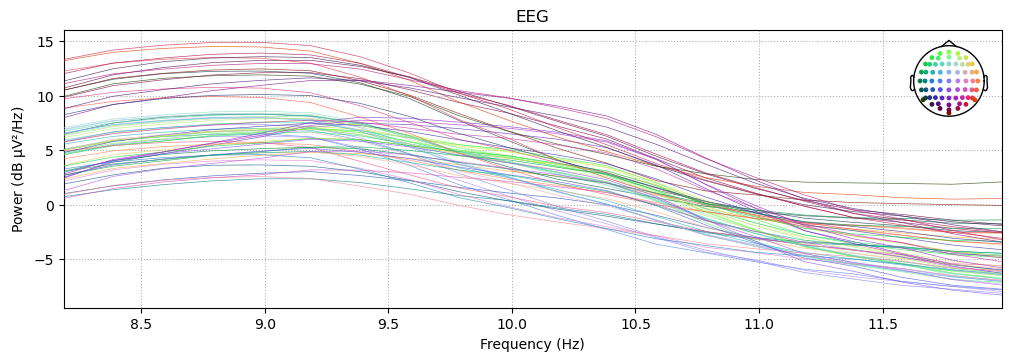

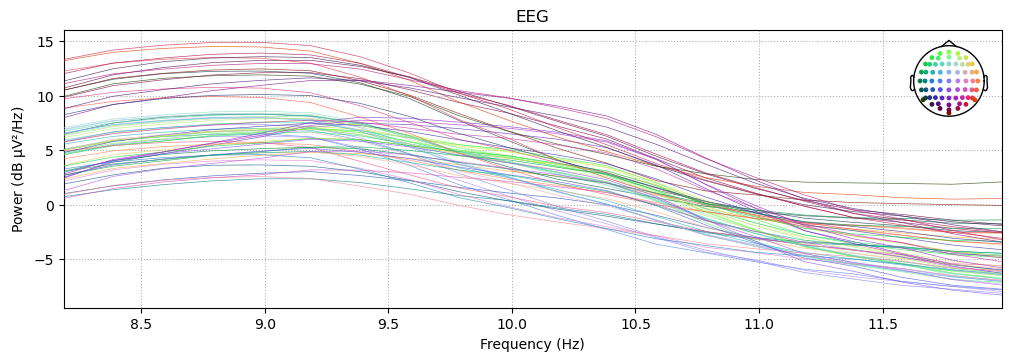

In [38]:
test_subject = load_epochs('internal_task', '078', 'med2', preload=True)

epo_spectrum = test_subject.compute_psd(method='multitaper', fmin=8, fmax=12, verbose=False, adaptive=True, normalization='full')
epo_spectrum.plot(dB=True, xscale='linear', average=False, spatial_colors=True, show=False)

Loading ./epochs/external_task/sub-11_ses-1_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/external_task/sub-11_ses-1_epo.fif ...
    Found the data of interest:
        t =   -5000.00 ...       0.00 ms
        0 CTF compensation matrices available
Not setting metadata
385 matching events found
No baseline correction applied
0 projection items activated
Loading ./epochs/external_task/sub-11_ses-2_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/external_task/sub-11_ses-2_epo.fif ...
    Found the data of interest:
        t =   -5000.00 ...       0.00 ms
        0 CTF compensation matrices available
Not setting metadata
317 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
702 matching events found
No baseline correction applied
Loading ./epochs/external_task/sub-11_ses-1_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/external_task/sub-11_ses-1_epo.fif ...
    Found the 

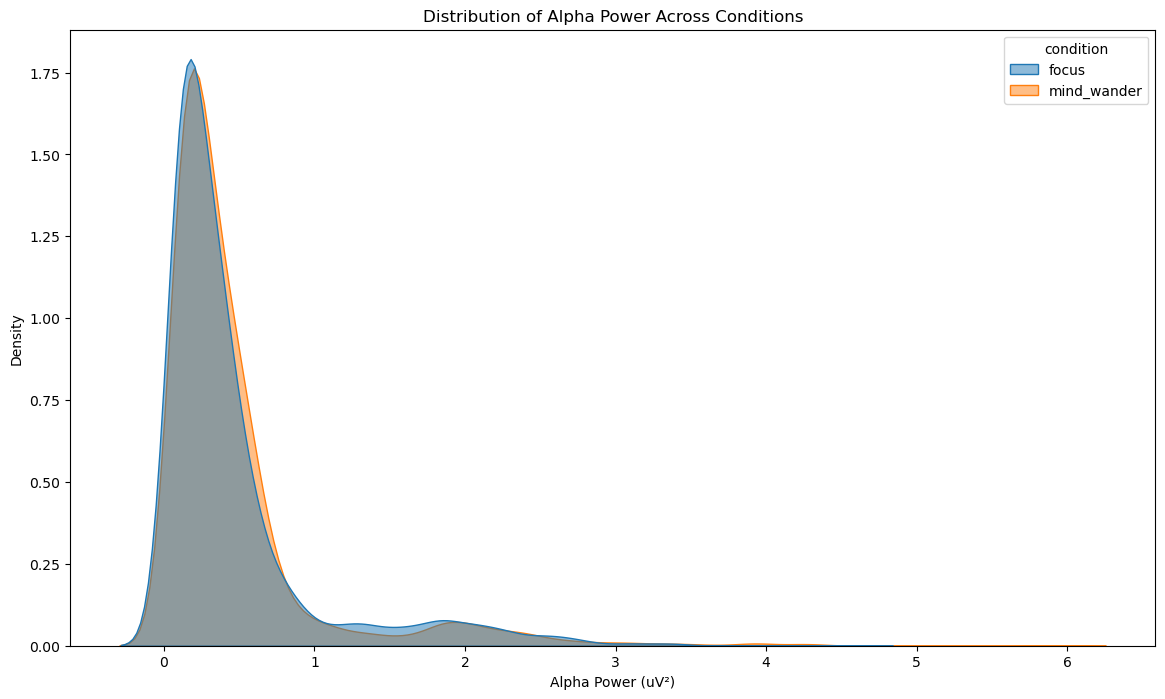

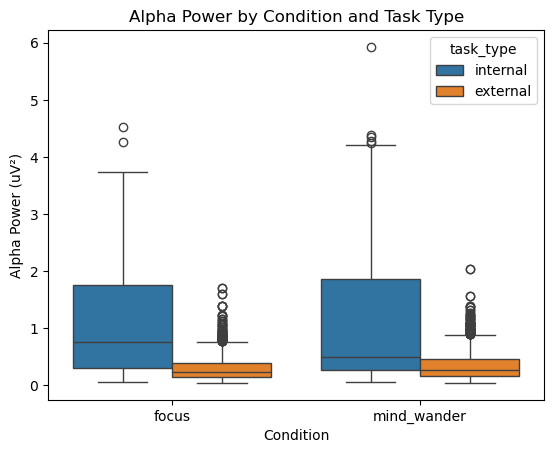

   subject_id task_type    condition      mean    median  variance
0         076  internal        focus  0.643922  0.667883  0.165178
1         076  internal  mind_wander  0.373995  0.357750  0.048661
2         072  internal        focus  0.120917  0.113696  0.002466
3         072  internal  mind_wander  0.134588  0.122897  0.002250
4         073  internal        focus  0.361248  0.356057  0.009306
5         073  internal  mind_wander  0.339428  0.335101  0.009796
6         074  internal        focus  1.850412  1.959395  0.891901
7         074  internal  mind_wander  2.040287  1.994004  1.701527
8         077  internal        focus  2.005117  1.961391  0.232162
9         077  internal  mind_wander  2.052681  2.045114  0.106575
10        078  internal        focus  0.586250  0.636865  0.064801
11        078  internal  mind_wander  0.388417  0.391846  0.011915
12        075  internal        focus  1.650560  1.730100  0.146656
13        075  internal  mind_wander  1.601281  1.656334  0.33

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel





# Example Usage
# Example input structure:
# subject_data = [
#     {'subject_id': '001', 'task_type': 'internal', 'focus_power': np.random.rand(100), 'mind_wander_power': np.random.rand(80)},
#     {'subject_id': '002', 'task_type': 'external', 'focus_power': np.random.rand(90), 'mind_wander_power': np.random.rand(85)},
# ]

# summary_df = analyze_multiple_subjects(subject_data)
# print(summary_df)

# Perform full computation for a single subject
task_type = 'external_task'
subject = '11'
frequency_band = 'alpha'
results = full_computation(task_type, subject, frequency_band, save=True)

# Extract the per-epoch power for focus and mind-wandering states
focus_power = results['focus']['per_epoch'] * 1e6  # Convert to µV^2
mw_power = results['mind_wander']['per_epoch'] * 1e6  # Convert to µV^2
subject_id = results['info']['subject']

base_path = './epochs'

# Identify all subjects in each task type
internal_subjects = [f.split('_')[0].split('-')[1] for f in os.listdir(os.path.join(base_path, 'internal_task')) if f.endswith('_epo.fif')]
external_subjects = [f.split('_')[0].split('-')[1] for f in os.listdir(os.path.join(base_path, 'external_task')) if f.endswith('_epo.fif')]

# Prepare subject data for analysis
subject_data = []

# Process internal task subjects
for subject_id in internal_subjects:
    results = full_computation('internal_task', subject_id, frequency_band, save=True)
    focus_power = results['focus']['per_epoch'] * 1e6  # Convert to µV^2
    mw_power = results['mind_wander']['per_epoch'] * 1e6  # Convert to µV^2
    subject_data.append({
        'subject_id': subject_id,
        'task_type': 'internal',
        'focus_power': focus_power,
        'mind_wander_power': mw_power
    })

# Process external task subjects
for subject_id in external_subjects:
    results = full_computation('external_task', subject_id, frequency_band, save=True)
    focus_power = results['focus']['per_epoch'] * 1e6  # Convert to µV^2
    mw_power = results['mind_wander']['per_epoch'] * 1e6  # Convert to µV^2
    subject_data.append({
        'subject_id': subject_id,
        'task_type': 'external',
        'focus_power': focus_power,
        'mind_wander_power': mw_power
    })




In [ ]:

# Define the function to analyze and visualize alpha power

def analyze_alpha_power(subjects_data):
    """
    Analyze and visualize alpha power statistics across multiple subjects.

    Parameters:
    - subjects_data (list): A list of dictionaries, each containing the subject data with the following keys:
        - 'subject_id': Identifier of the subject.
        - 'task_type': 'internal_task' or 'external_task'.
        - 'state': 'focus' or 'mind_wandering'.
        - 'alpha_power': Array of alpha power values for the corresponding state.

    Returns:
    - None: Generates statistical analysis and visualizations.
    """

    # Organize data into a dataframe
    records = []
    for data in subjects_data:
        for state, alpha_power in data['alpha_power'].items():
            for power in alpha_power:
                records.append({
                    'Subject': data['subject_id'],
                    'Task Type': data['task_type'],
                    'State': state,
                    'Alpha Power': power
                })

    df = pd.DataFrame(records)

    # Compute summary statistics
    summary = df.groupby(['Task Type', 'State']).agg({
        'Alpha Power': ['mean', 'median', 'var']
    })

    print("Summary Statistics:\n")
    print(summary)

    # Generate visualizations
    plt.figure(figsize=(12, 8))

    # KDE Plot: Alpha Power Distribution
    sns.kdeplot(data=df, x='Alpha Power', hue='State', fill=True, common_norm=False)
    plt.title("Alpha Power Distribution by State")
    plt.xlabel("Alpha Power")
    plt.ylabel("Density")
    plt.show()

    # Boxplot: Alpha Power by Task Type and State
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x='Task Type', y='Alpha Power', hue='State')
    plt.title("Alpha Power Comparison by Task Type and State")
    plt.xlabel("Task Type")
    plt.ylabel("Alpha Power")
    plt.show()

    # Analyze hypothesis - Alpha power sequence: External Focus > MW (external) > MW (internal) > Internal Focus
    hypothesis_results = []

    # Separate data into categories
    external_focus = df[(df['Task Type'] == 'external_task') & (df['State'] == 'focus')]['Alpha Power']
    mw_external = df[(df['Task Type'] == 'external_task') & (df['State'] == 'mind_wandering')]['Alpha Power']
    mw_internal = df[(df['Task Type'] == 'internal_task') & (df['State'] == 'mind_wandering')]['Alpha Power']
    internal_focus = df[(df['Task Type'] == 'internal_task') & (df['State'] == 'focus')]['Alpha Power']

    # Perform t-tests for each comparison
    comparisons = [
        ('External Focus > MW External', external_focus, mw_external),
        ('MW External > MW Internal', mw_external, mw_internal),
        ('MW Internal > Internal Focus', mw_internal, internal_focus)
    ]

    for name, group1, group2 in comparisons:
        t_stat, p_value = ttest_rel(group1, group2, nan_policy='omit')
        hypothesis_results.append({
            'Comparison': name,
            'Mean Difference': np.nanmean(group1) - np.nanmean(group2),
            't-statistic': t_stat,
            'p-value': p_value
        })

    results_df = pd.DataFrame(hypothesis_results)

    print("\nHypothesis Test Results:\n")
    print(results_df)

    # Visualization of the hypothesis test results
    plt.figure(figsize=(8, 6))
    sns.barplot(data=results_df, x='Comparison', y='Mean Difference', hue='p-value', dodge=False)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.title("Hypothesis Test Mean Differences")
    plt.ylabel("Mean Difference in Alpha Power")
    plt.xlabel("Comparison")
    plt.xticks(rotation=15)
    plt.show()

# Analyze the collected subject data
summary_df = analyze_alpha_power(subject_data)
print(summary_df)

SyntaxError: invalid syntax (378135498.py, line 6)

In [33]:
# Extract the per-epoch power for focus and mind-wandering states
focus_power = results['focus']['per_epoch']
mw_power = results['mind_wander']['per_epoch']

x = np.concatenate([focus_power, mw_power])
print(x)

[1.24995050e-07 1.36981229e-07 1.55692136e-07 1.16102965e-07
 1.55313976e-07 1.10552389e-07 1.07412109e-07 7.95904630e-08
 2.01899897e-07 1.04365039e-07 8.50524872e-08 1.35872722e-07
 1.84555665e-07 1.18681675e-07 1.18405052e-07 2.01727653e-07
 1.91583640e-07 1.20534308e-07 1.26219433e-07 2.37515247e-07
 2.42077057e-07 9.36027631e-08 1.16989465e-07 9.00564968e-08
 7.75127393e-08 1.09325615e-07 6.70114676e-08 7.84592840e-08
 1.65313151e-07 7.52194864e-08 9.50039166e-08 1.82006070e-07
 1.51097037e-07 1.25643063e-07 1.06939457e-07 1.91561559e-07
 1.88549231e-07 1.27016452e-07 1.91062189e-07 2.54687940e-07
 3.80261876e-07 1.00948295e-07 8.82819224e-08 7.38475829e-08
 9.66954924e-08 1.20648768e-07 9.00702109e-08 1.28428551e-07
 1.11537244e-07 1.76377767e-07 8.91357101e-08 1.43212705e-07
 8.66630638e-08 1.53445930e-07 1.10637701e-07 1.05272388e-07
 7.44622207e-08 1.13231554e-07 1.13654557e-07 1.49583598e-07
 1.55101122e-07 1.21677376e-07 1.34617963e-07 1.37498864e-07
 1.79825112e-07 1.660183

In [23]:
subject_7_focus_per_epoch_per_channel = results['focus']['per_epoch_per_channel']

subject_7_focus_per_epoch = results['focus']['per_epoch']

sub7_focus_mean = results['focus']['mean']
sub7_focus_total_power = results['focus']['total_power'] / len(results['focus']['per_epoch'])

sub7_diff_mean = results['difference']['mean']
sub7_diff_total_power = results['difference']['total_adjusted_difference']

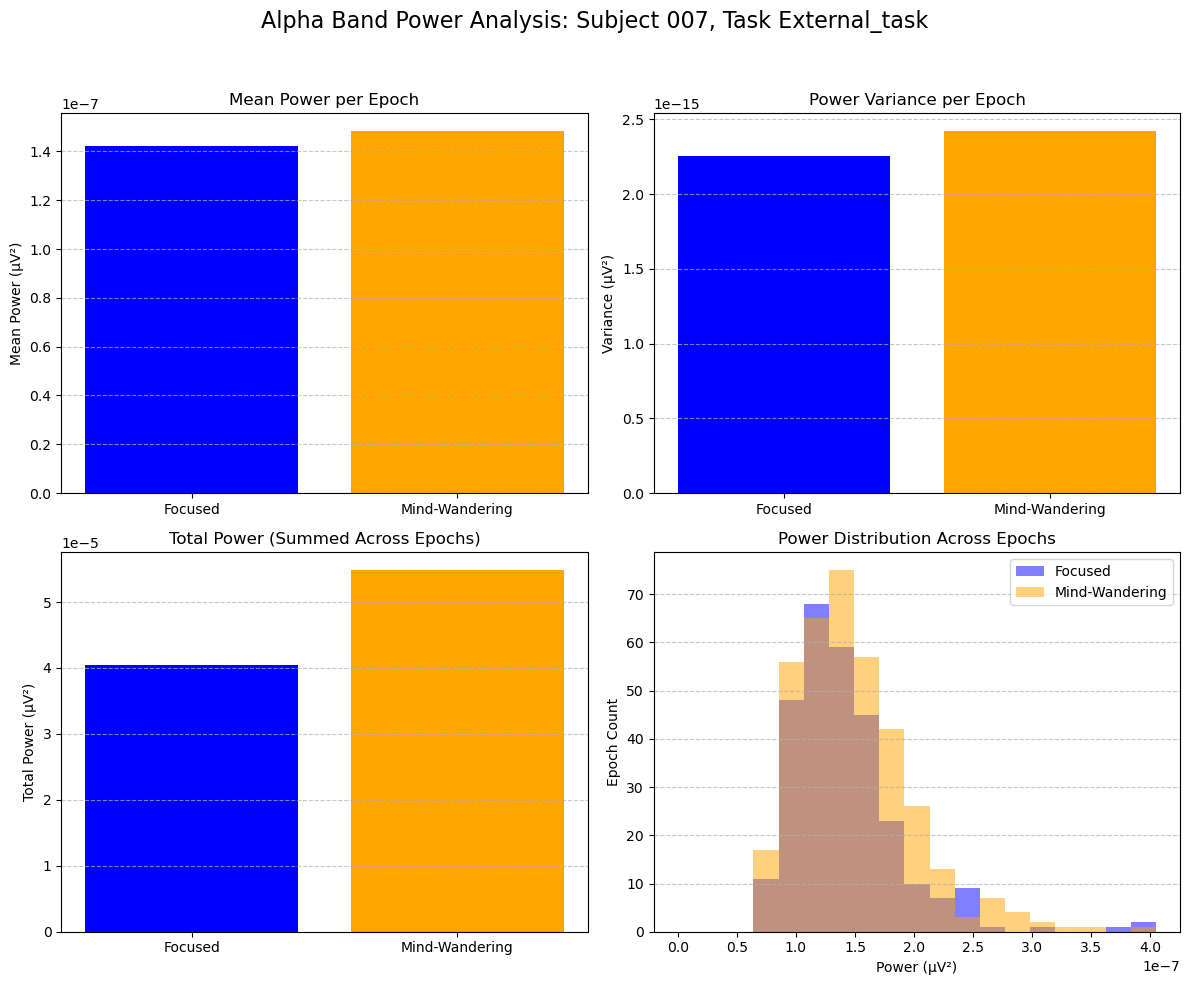

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(results_focus, results_mw, subject, task_type, frequency_band='alpha'):
    """
    Visualize the computed power results for focused and mind-wandering states.

    Parameters:
    - results_focus (dict): Computed power results for the focused state.
    - results_mw (dict): Computed power results for the mind-wandering state.
    - subject (str): Subject identifier (e.g., '001').
    - task_type (str): Task type ('internal_task' or 'external_task').
    - frequency_band (str): Frequency band analyzed (default: 'alpha').

    Returns:
    - None: Displays the plots.
    """
    # Extract data
    mean_focus = results_focus['mean']
    mean_mw = results_mw['mean']
    var_focus = results_focus['variance']
    var_mw = results_mw['variance']
    total_focus = results_focus['total_power']
    total_mw = results_mw['total_power']
    
    per_epoch_focus = results_focus['per_epoch']
    per_epoch_mw = results_mw['per_epoch']
    
    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Alpha Band Power Analysis: Subject {subject}, Task {task_type.capitalize()}", fontsize=16)

    # Plot 1: Mean Power Comparison
    axes[0, 0].bar(['Focused', 'Mind-Wandering'], [mean_focus, mean_mw], color=['blue', 'orange'])
    axes[0, 0].set_title('Mean Power per Epoch')
    axes[0, 0].set_ylabel('Mean Power (µV²)')
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Variance Comparison
    axes[0, 1].bar(['Focused', 'Mind-Wandering'], [var_focus, var_mw], color=['blue', 'orange'])
    axes[0, 1].set_title('Power Variance per Epoch')
    axes[0, 1].set_ylabel('Variance (µV²)')
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 3: Total Power Comparison
    axes[1, 0].bar(['Focused', 'Mind-Wandering'], [total_focus, total_mw], color=['blue', 'orange'])
    axes[1, 0].set_title('Total Power (Summed Across Epochs)')
    axes[1, 0].set_ylabel('Total Power (µV²)')
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 4: Per-Epoch Power Distribution
    bins = np.linspace(0, max(max(per_epoch_focus), max(per_epoch_mw)), 20)
    axes[1, 1].hist(per_epoch_focus, bins, alpha=0.5, label='Focused', color='blue')
    axes[1, 1].hist(per_epoch_mw, bins, alpha=0.5, label='Mind-Wandering', color='orange')
    axes[1, 1].set_title('Power Distribution Across Epochs')
    axes[1, 1].set_xlabel('Power (µV²)')
    axes[1, 1].set_ylabel('Epoch Count')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Example: Compute results for subject 001 and alpha band
results_focus = results['focus']
results_mw = results['mind_wander']

# Visualize the results
visualize_results(results_focus, results_mw, subject='007', task_type='external_task', frequency_band='alpha')


Loading ./epochs/internal_task/sub-078_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/internal_task/sub-078_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
227 matching events found
No baseline correction applied
0 projection items activated
Loading ./epochs/internal_task/sub-078_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/internal_task/sub-078_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
227 matching events found
No baseline correction applied
0 projection items activated


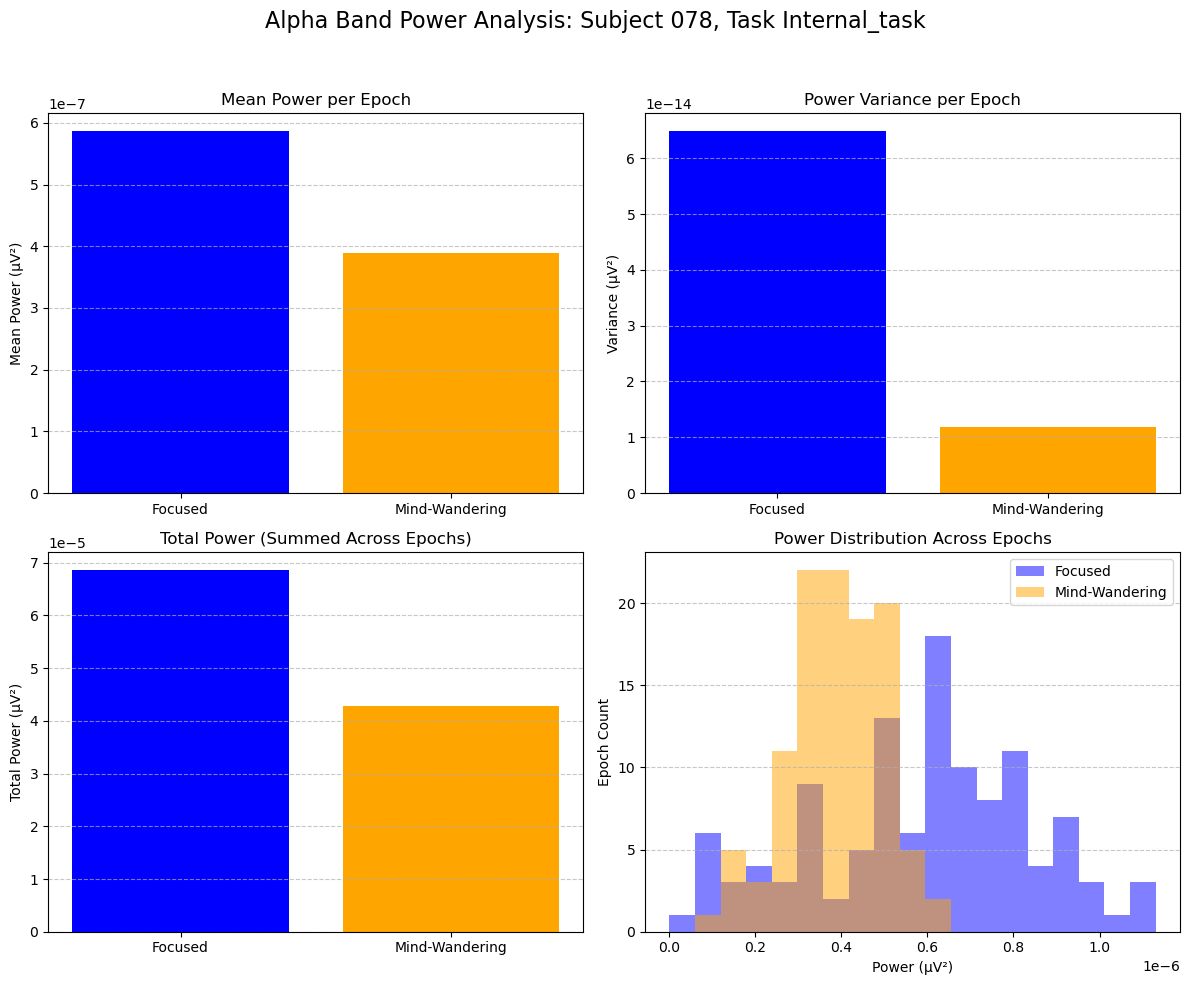

In [12]:
results = full_computation('internal_task', '78', 'alpha')

results_focus = results['focus']
results_mw = results['mind_wander']

# Visualize the results
visualize_results(results_focus, results_mw, subject='078', task_type='internal_task', frequency_band='alpha')

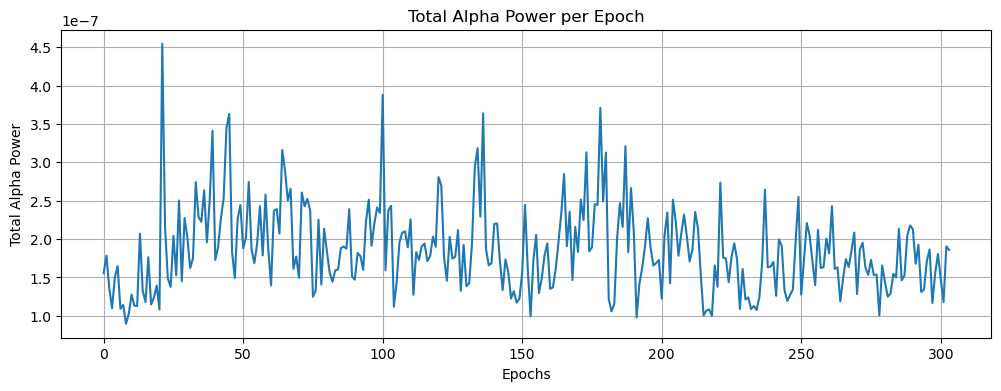

In [55]:
# Define the alpha band
fmin, fmax = 7.5, 12.5  # Alpha band range in Hz

# Compute the PSD for the epochs
psd = epochs.compute_psd(method='multitaper', fmin=fmin, fmax=fmax, verbose=False)

# Get the frequency values (if needed)
freqs = psd.freqs  # Array of frequency bins

# Extract the PSD data
psd_data = psd.get_data()  # Shape: (n_epochs, n_channels, n_freqs)

# Sum the power in the alpha band for each channel in each epoch
alpha_power_per_epoch_per_channel = np.sum(psd_data, axis=-1)  # Sum across the frequency axis

# Compute the total alpha power for each epoch (sum across channels)
total_alpha_power_per_epoch = np.sum(alpha_power_per_epoch_per_channel, axis=1)

# Finding the mean and variance of the total alpha power
mean_alpha_power = np.mean(total_alpha_power_per_epoch)
var_alpha_power = np.var(total_alpha_power_per_epoch)


# Plot the total alpha power for each epoch
plt.figure(figsize=(12, 4))
plt.plot(range(len(total_alpha_power_per_epoch)), total_alpha_power_per_epoch, marker='')
plt.title('Total Alpha Power per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Total Alpha Power')
plt.grid(True)
plt.show()



In [ ]:
def compute_state_power_difference()

In [ ]:
import pickle

# Define the data to be saved
data_to_save = {
    'alpha_power_per_epoch_per_channel': alpha_power_per_epoch_per_channel,
    'epochs': epochs,
    'fmax': fmax,
    'fmin': fmin,
    'freqs': freqs,
    'mean_alpha_power': mean_alpha_power,
    'psd': psd,
    'psd_data': psd_data,
    'state': state,
    'subject': subject,
    'task': task,
    'task_type': task_type,
    'total_alpha_power_per_epoch': total_alpha_power_per_epoch,
    'var_alpha_power': var_alpha_power
}

# Create the directory if it doesn't exist
os.makedirs('power_data', exist_ok=True)

# Define the file name
file_name = f'power_data/{task_type}_sub-{subject}_{task}_{state}.pkl'

# Save the data to a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(data_to_save, file)

No baseline correction applied


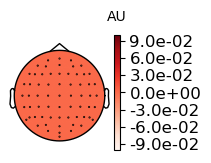

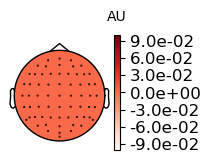

In [ ]:
# Plot the epochs in time-frequency domain
frequencies = np.arange(7, 13, 3)
power = epochs.compute_tfr(
    "multitaper", n_jobs=1, return_itc=False, freqs=frequencies, average=True
)
power.plot_topomap()

{'Fp1': [4.346277503406588e-07, 3.3975607973128265e-06, 5.3211129451529865e-06, 3.82042845342421e-06, 4.789696218548203e-06, 2.337340730493295e-06, 6.579647578184804e-06, 3.7929859429233756e-06, 3.3756578479767186e-06, 2.4051478966346133e-06, 4.979709952926564e-06, 2.2889200368433298e-06, 1.9413615926436503e-06, 6.096055439923318e-07, 1.6087416549497236e-07, 2.9675860428194546e-06, 3.722488997909751e-06, 1.1959614910066725e-06, 2.0245819618592545e-06, 3.84809801582685e-06, 2.1631579352580463e-06, 1.2570150150849122e-06, 9.374174412585729e-07, 1.2671876259834545e-07, 4.288463232713406e-08, 9.23447764410559e-08, 2.3090477701249853e-07, 4.2287755094328246e-07, 4.832730914710133e-06, 3.7519942848146588e-06, 8.860598747729342e-07, 4.463392997231141e-06, 3.2156680492401305e-06, 3.337900016837197e-06, 5.023887246699257e-06, 2.5095908799170154e-06, 2.22927956291796e-06, 2.0869666183198484e-06, 3.909172170462802e-06, 3.3603275532450993e-06, 7.859564000608071e-07, 8.848790413543241e-07, 5.092774

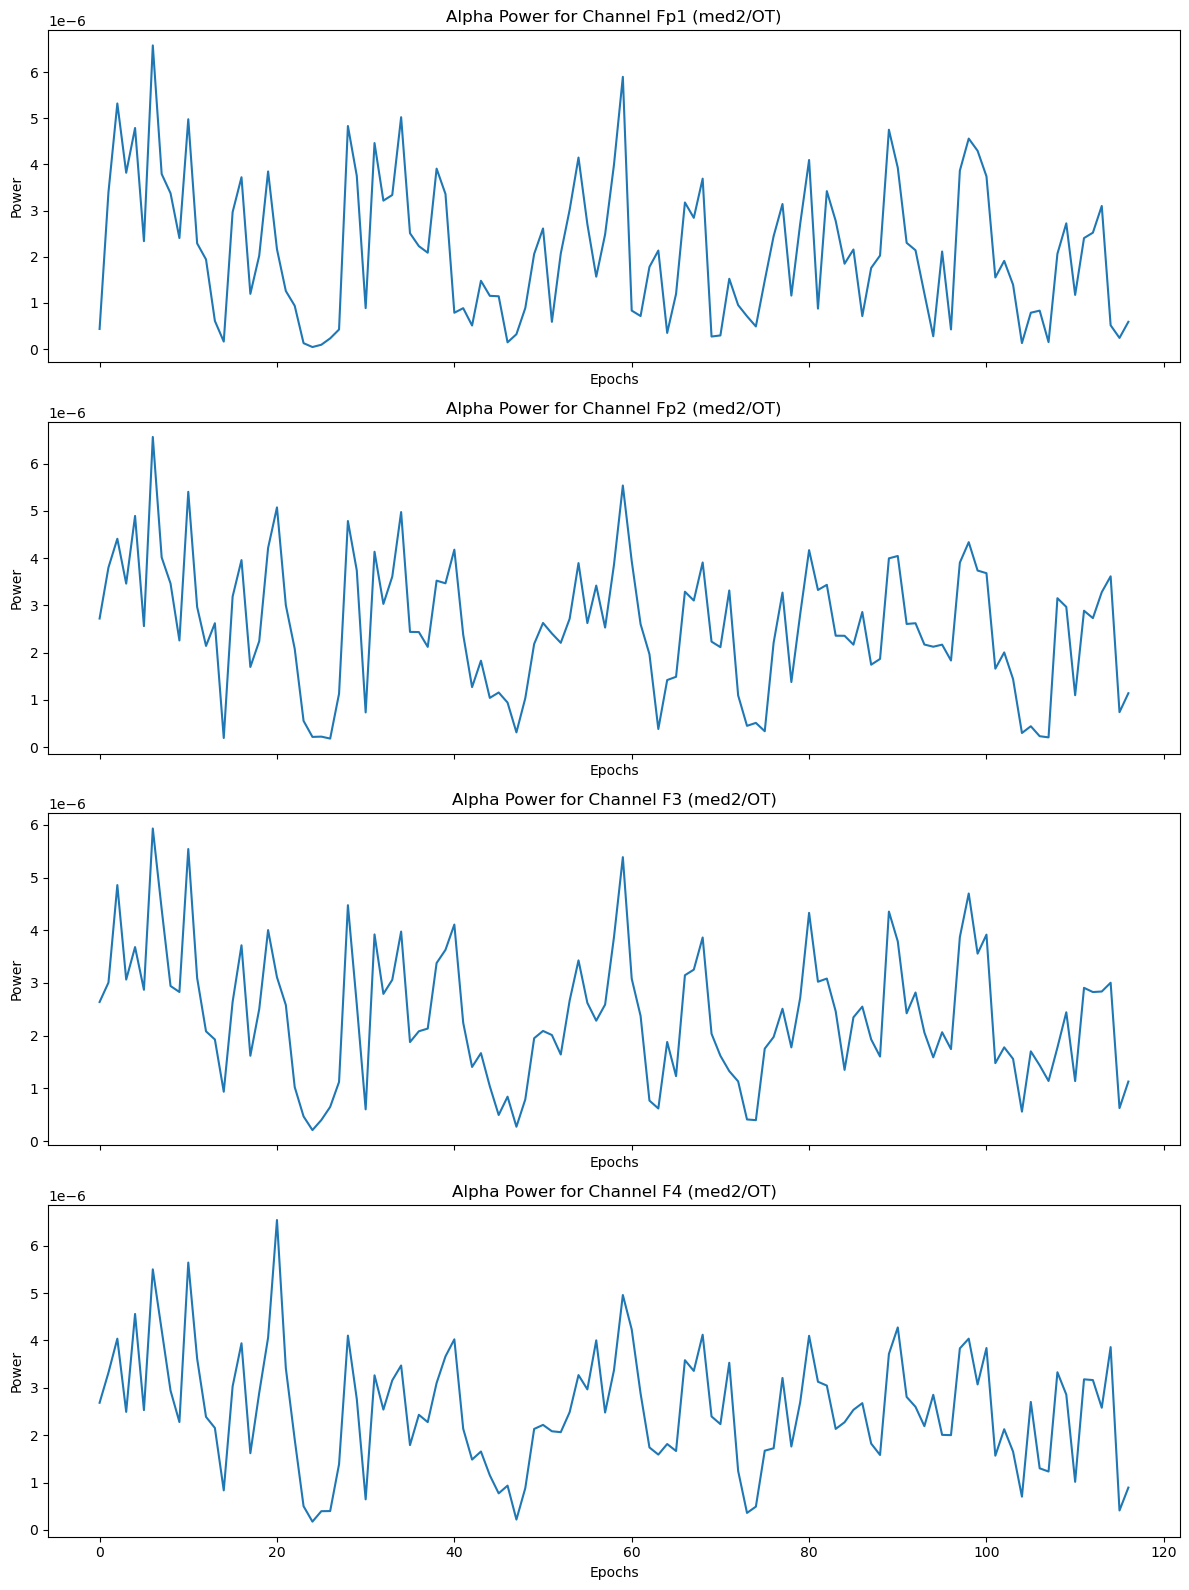

[3.425107094111997e-06, 3.670031332633911e-06, 6.218163206722187e-06, 3.965065863010231e-06, 5.205305244924686e-06, 4.655812490065406e-06, 6.144195014577614e-06, 5.389183235835355e-06, 3.895328271270067e-06, 3.5046356717920095e-06, 6.65269373942881e-06, 4.068740577100032e-06, 2.8558819059376976e-06, 2.534446169291834e-06, 1.3846931484820689e-06, 3.911268272016338e-06, 4.676902913747048e-06, 3.43884040551776e-06, 4.442826984941814e-06, 4.740333518854293e-06, 4.91954489277114e-06, 3.670064652761201e-06, 1.8663059464419413e-06, 6.740060945354132e-07, 2.7689830322217953e-07, 5.337992423384541e-07, 5.541125901102247e-07, 2.0560840188930937e-06, 4.19758908399173e-06, 3.688589173379343e-06, 1.1938408627271222e-06, 4.86564801464827e-06, 3.0843176237644162e-06, 3.6501069998275445e-06, 4.08712607489711e-06, 2.300149317755659e-06, 3.1734383135688465e-06, 3.6724787487735676e-06, 4.62193154691763e-06, 4.544303243891701e-06, 4.32381824126619e-06, 2.681054898524354e-06, 1.7944874324771888e-06, 1.8975

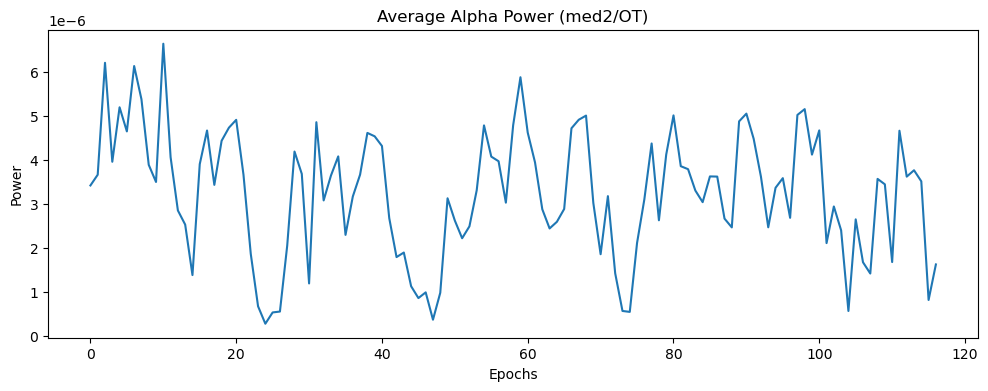

In [ ]:


def compute_alpha_band_power(epochs, freqs_range=(8, 12), sum_power=True):
    """
    Compute the alpha-band power for each channel in each epoch.
    
    Parameters:
    - epochs (mne.Epochs): The epochs object containing the data.
    - freqs_range (tuple): The frequency range for the alpha band (default is (8, 12)).
    - sum_power (bool): Whether to sum the power across the frequency range or return individual frequencies.
    
    Returns:
    - alpha_power (dict): A dictionary with channel names as keys and lists of alpha power for each epoch as values.
    """
    alpha_power = {ch: [] for ch in epochs.ch_names}
    sfreq = epochs.info['sfreq']
    n_samples = epochs.get_data().shape[2]
    
    for epoch in epochs.get_data():
        for ch_idx, ch_name in enumerate(epochs.ch_names):
            ch_data = epoch[ch_idx]
            # Perform FFT
            fft_vals = fft(ch_data)
            fft_freqs = fftfreq(n_samples, 1/sfreq)
            
            # Compute power for each frequency in the alpha band
            power = np.abs(fft_vals)**2
            alpha_band_power = []
            for freq in range(freqs_range[0], freqs_range[1] + 1):
                freq_idx = np.where((fft_freqs >= freq - 0.5) & (fft_freqs < freq + 0.5))[0]
                alpha_band_power.append(np.sum(power[freq_idx]))
            
            if sum_power:
                alpha_power[ch_name].append(np.sum(alpha_band_power))
            else:
                alpha_power[ch_name].append(alpha_band_power)
    
    return alpha_power

# Compute alpha-band power for each channel in each epoch
alpha_power = compute_alpha_band_power(epochs, sum_power=True)
print(alpha_power)

# plot the alpha power for each channel

def plot_alpha_power(alpha_power, ch_names, task, state):
    """
    Plot the alpha power for each channel in the given task and state.
    
    Parameters:
    - alpha_power (dict): A dictionary with channel names as keys and lists of alpha power for each epoch as values.
    - ch_names (list): List of channel names to plot.
    - task (str): Task name.
    - state (str): State name.
    """
    n_epochs = len(alpha_power[ch_names[0]])
    n_channels = len(ch_names)
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 4 * n_channels), sharex=True)
    
    for i, ch_name in enumerate(ch_names):
        axes[i].plot(range(n_epochs), alpha_power[ch_name])
        axes[i].set_title(f'Alpha Power for Channel {ch_name} ({task}/{state})')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel('Power')
    
    plt.tight_layout()
    plt.show()

# Plot the alpha power for each channel
ch_names = ['Fp1', 'Fp2', 'F3', 'F4']
plot_alpha_power(alpha_power, ch_names, task, state)

# Compute the average alpha power across channels
def compute_avg_alpha_power(alpha_power):
    """
    Compute the average alpha power across channels for each epoch.
    
    Parameters:
    - alpha_power (dict): A dictionary with channel names as keys and lists of alpha power for each epoch as values.
    
    Returns:
    - avg_alpha_power (list): A list of average alpha power values for each epoch.
    """
    avg_alpha_power = []
    for i in range(len(alpha_power[list(alpha_power.keys())[0]])):
        avg_power = np.mean([alpha_power[ch][i] for ch in alpha_power])
        avg_alpha_power.append(avg_power)
    
    return avg_alpha_power

# Compute the average alpha power across channels
avg_alpha_power = compute_avg_alpha_power(alpha_power)
print(avg_alpha_power)

# Plot the average alpha power across channels
plt.figure(figsize=(12, 4))
plt.plot(range(len(avg_alpha_power)), avg_alpha_power)
plt.title(f'Average Alpha Power ({task}/{state})')
plt.xlabel('Epochs')
plt.ylabel('Power')

plt.show()

